### Попытка окна №1 (размерности странные и величины)

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, fftshift, fftfreq

nx_max = 1500
ny_max = 60
dt_step = 0.001
x_frac_start = 0.3 
x_frac_end = 0.8
t_start = 0.7

In [71]:
filename = f"./data/s2d_film_time_statistic_{nx_max}_{ny_max}.dat"
with open(filename, "r") as f:
    first_line = f.readline().strip()
    dx_step = float(first_line)

tf_ind = int(t_start/dt_step)
xf_ind = int(x_frac_start*nx_max)
xl_ind = int(x_frac_end*nx_max)
data = np.loadtxt(filename, skiprows=2, delimiter=',')
data = data[:, 1:]*1.0e3 

In [72]:

#Попытка 2D-анализа для сигнала в каждой отдельной точке с выводом на график
#список с значениям получившихся длин волн в точках от 0 до 1500
lenght_waves = list()
#список с значениям получившихся частот в точках от 0 до 1500
freq_waves = list()
#список с значениям получившихся фазовых скоростей в точках от 0 до 1500
uw_waves = list()
#координаты для графика
x_positions = list()

window_size_x = 25
step_x = 1
for start_x in range(0, nx_max - window_size_x + 1, step_x):
    end_x = start_x + window_size_x
    data_window = data[:, start_x:end_x]
    data_detrend = data_window - np.mean(data_window, axis=1, keepdims=True)
    nt, nx_local = data_detrend.shape
    #тут 2D FFT
    win_t = np.hanning(nt)[:, None]
    win_x = np.hanning(nx_local)[None, :]
    data_win = data_detrend * win_t * win_x
    spec2 = fftshift(fft2(data_win))
    power = np.abs(spec2)**2 
    freqs = fftshift(fftfreq(nt, d=dt_step))     # шт / t-ед.
    wavenums = fftshift(fftfreq(nx_local, d=dt_step))  # шт / x-ед
    power_flat = power.copy()
    peak_idx = np.unravel_index(np.argmax(power_flat), power_flat.shape)
    f_peak = freqs[peak_idx[0]]
    k_peak = wavenums[peak_idx[1]]
    if k_peak != 0:
        u_phase = f_peak / k_peak
    else:
        u_phase = np.nan
    lambda_phys = 1 / (k_peak / dx_step)       # длина волны, м
    freq_phys = f_peak / dt_step                     # частота, Гц
    u_phys = freq_phys * lambda_phys            # фазовая скорость, м/с
    x_center = start_x + window_size_x // 2
    x_positions.append(x_center)
    #обработка
    lenght_waves.append(np.abs(lambda_phys*100) if not np.isnan(lambda_phys) else 0)
    freq_waves.append(np.abs(freq_phys) if not np.isnan(freq_phys) else 0)
    uw_waves.append(np.abs(u_phys*100) if not np.isnan(u_phys) else 0)

In [73]:
#set(list(lenght_waves))

In [74]:
#set(list(freq_waves))

In [75]:
#set(list(uw_waves))

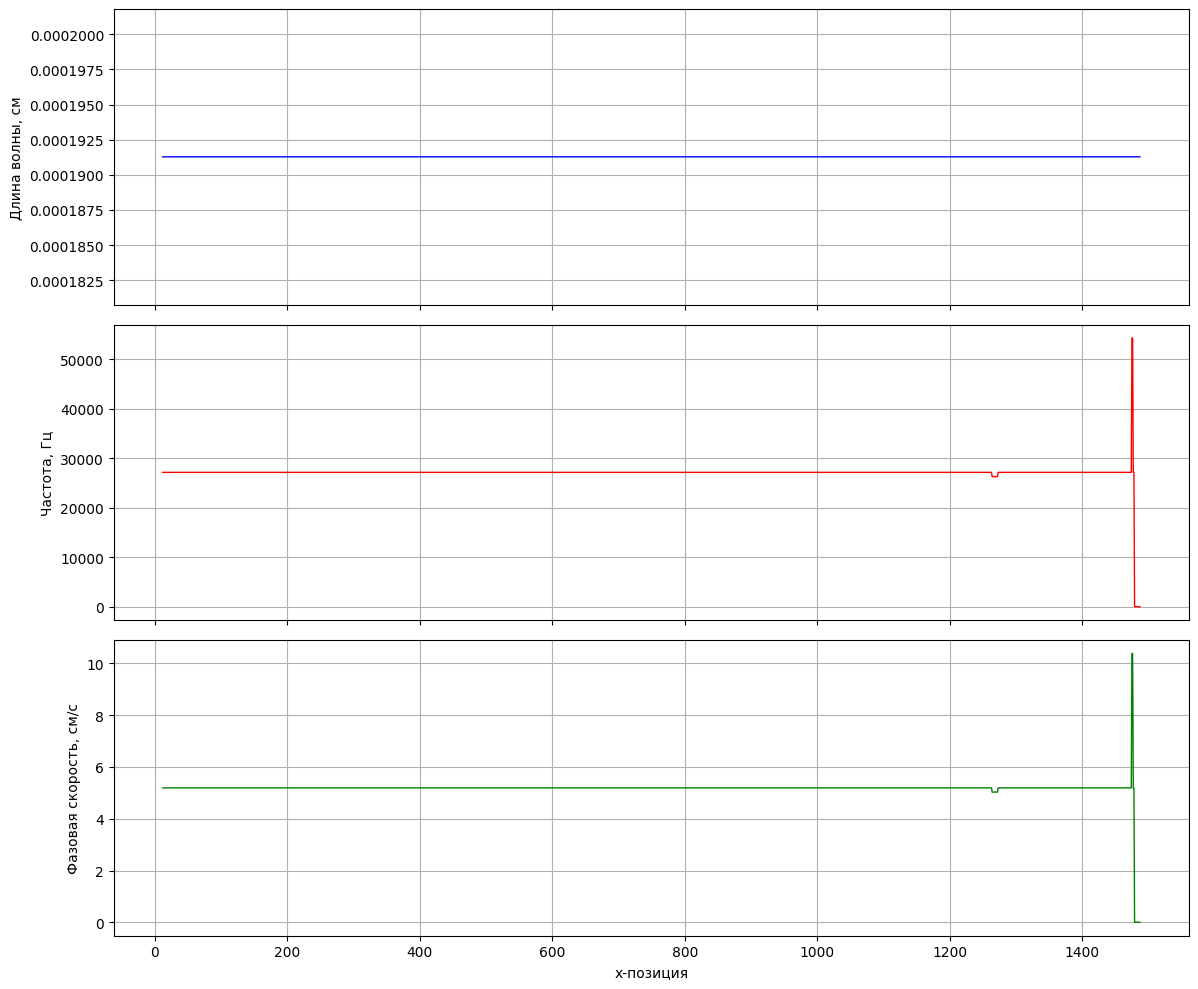

In [76]:
lenght_waves = np.array(lenght_waves)
freq_waves = np.array(freq_waves)
uw_waves = np.array(uw_waves)

# ymin0, ymax0 = 0.815, 0.825
# ymin1, ymax1 = 27.0, 27.1
# ymin2, ymax2 = 21., 23.

fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
axes[0].plot(x_positions, lenght_waves, 'b-', linewidth=1)
axes[0].set_ylabel('Длина волны, см')
#axes[0].set_ylim(ymin0, ymax0)
axes[0].grid(True)
axes[1].plot(x_positions, freq_waves, 'r-', linewidth=1)
axes[1].set_ylabel('Частота, Гц')
#axes[1].set_ylim(ymin1, ymax1)
axes[1].grid(True)
axes[2].plot(x_positions, uw_waves, 'g-', linewidth=1)
axes[2].set_ylabel('Фазовая скорость, см/с')
axes[2].set_xlabel('x-позиция')
#axes[2].set_ylim(ymin2, ymax2)
axes[2].grid(True)
plt.tight_layout()
plt.show()

### Поиск максимальной амплитуды в каждой точке

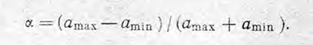

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import pandas as pd

nx_max = 1500
ny_max = 60
dt_step = 0.001
x_frac_start = 0.3 
x_frac_end = 0.8
t_start = 0.7

In [4]:
filename = f"./data/s2d_film_time_statistic_{nx_max}_{ny_max}.dat"
with open(filename, "r") as f:
    first_line = f.readline().strip()
    dx_step = float(first_line)
tf_ind = int(t_start/dt_step)
xf_ind = int(x_frac_start*nx_max)
xl_ind = int(x_frac_end*nx_max)
data = np.loadtxt(filename, skiprows=2, delimiter=',')
data_time = data[:, 0]
data = data[:, 1:]*1.0e3

#### Для последнего момента времени

Размер x_coords: (1500,)
Размер data_slice: (1500,)


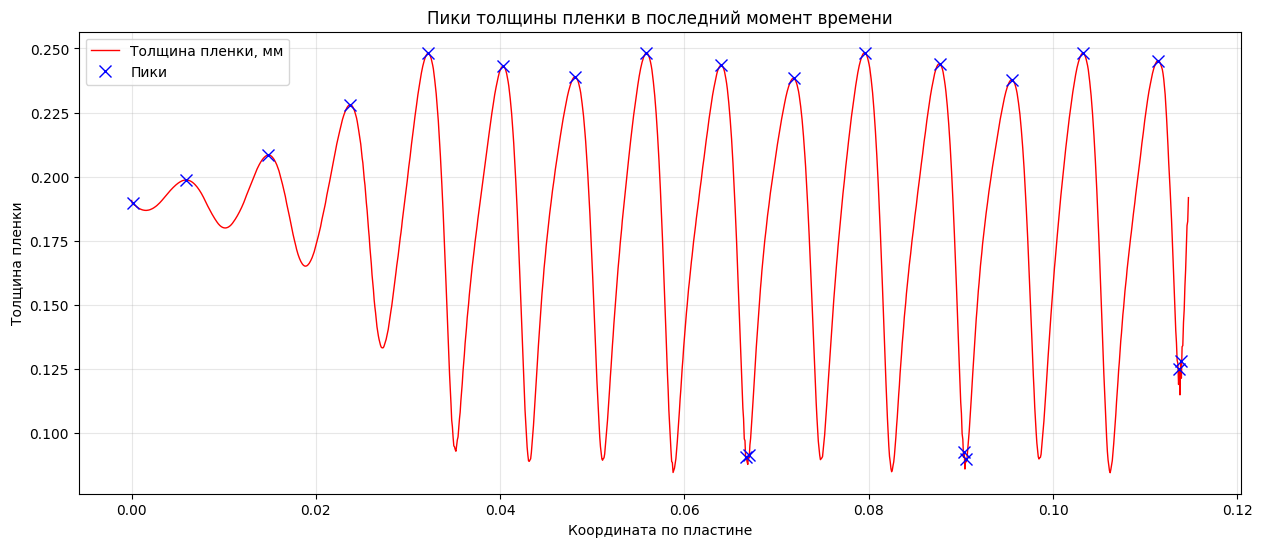

In [5]:
time_slice = -1  #последний момент времени
data_slice = data[time_slice, :]  #массив по пространству
peaks_ind = []
peaks_values = []
#находим пики по пространственной координате
peaks, properties = find_peaks(data_slice)
peaks_ind.append(peaks)
peaks_values = data_slice[peaks]
x_coords = np.arange(0, dx_step * len(data_slice), dx_step)
print(f"Размер x_coords: {x_coords.shape}")
print(f"Размер data_slice: {data_slice.shape}")
plt.figure(figsize=(15, 6))
plt.plot(x_coords, data_slice, 'r-', linewidth=1, label='Толщина пленки, мм')
plt.plot(x_coords[peaks], peaks_values, 'xb', markersize=8, label='Пики')
plt.xlabel('Координата по пластине')
plt.ylabel('Толщина пленки')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title(f'Пики толщины пленки в последний момент времени')
plt.show()

#### Для всех времен

In [6]:
peaks_ind = []
peaks_values = []
x_coords = []
max_peaks = []
min_peaks = []
ampl_waves = []
for i in range(len(list(data_time))):
    data_slice = data[i, :]  #массив по пространству
    peaks, properties = find_peaks(data_slice)
    peaks_ind.append(peaks)
    peaks_values.append(data_slice[peaks])
    #есть ли пик
    if len(peaks) > 0:
        current_peaks = data_slice[peaks]
        peaks_values.append(current_peaks)
        max_peaks.append(np.max(current_peaks))
        min_peaks.append(np.min(current_peaks))
        ampl_waves.append((np.max(current_peaks) - np.min(current_peaks))/(np.max(current_peaks) + np.min(current_peaks)))
    else:
        #nan
        peaks_values.append(np.array([]))
        max_peaks.append(np.nan)
        min_peaks.append(np.nan)
        ampl_waves.append(np.nan)

C:\Users\Uluana\AppData\Local\Temp\ipykernel_12620\1602166938.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


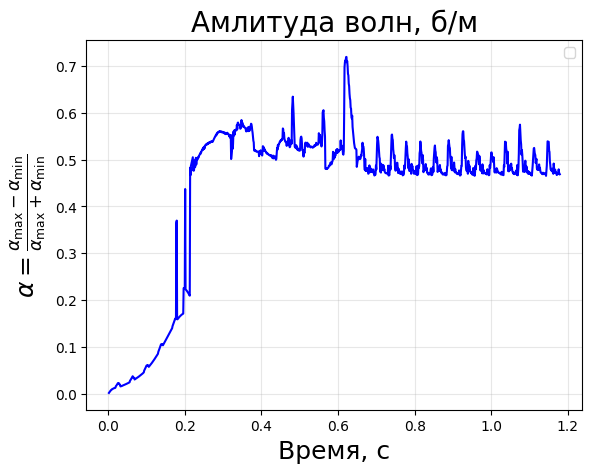

In [7]:
plt.plot(data_time,ampl_waves, 'b-')
plt.xlabel('Время, с', fontsize=18)
plt.ylabel(r'$\alpha = \frac{\alpha_{\max} - \alpha_{\min}}{\alpha_{\max} + \alpha_{\min}}$', fontsize=18)
plt.legend()
plt.grid(True, alpha=0.3)
plt.title(f'Амлитуда волн, б/м', fontsize=20)
plt.show()

In [8]:
index = np.argmax(data_time[data_time>0.7])

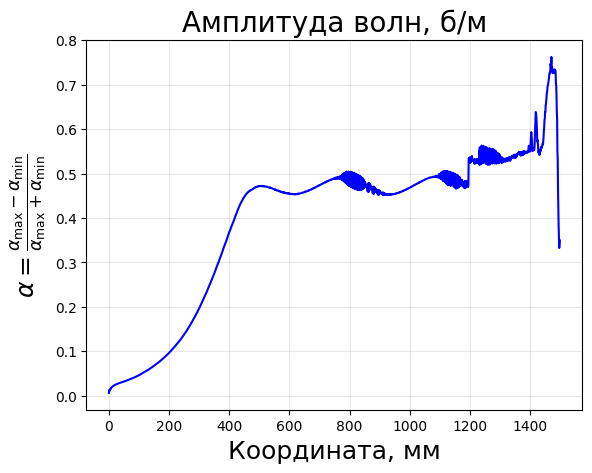

In [9]:
peaks_ind_max = []
peaks_ind_min = []
peaks_values_max = []
peaks_values_min = []
x_coords = []
max_peaks = []
min_peaks = []
ampl_waves = []

for i in range(nx_max):
    data_slice = data[index:, i]  #массив по времени
    #максимумы
    peaks_max, _ = find_peaks(data_slice)
    peaks_ind_max.append(peaks_max)
    peaks_values_max.append(data_slice[peaks_max])
    #минимумы
    peaks_min, _ = find_peaks(-data_slice)
    peaks_ind_min.append(peaks_min)
    peaks_values_min.append(data_slice[peaks_min])
    #берем последний максимум и минимум для расчета амплитуды
    if len(peaks_max) > 0 and len(peaks_min) > 0:
        current_max = np.max(data_slice[peaks_max])
        current_min = np.min(data_slice[peaks_min])
        max_peaks.append(current_max)
        min_peaks.append(current_min)
        if current_max + current_min != 0:
            amplitude = (current_max - current_min) / (current_max + current_min)
            ampl_waves.append(amplitude)
x_coords = np.arange(0, len(ampl_waves), 1)

plt.plot(x_coords, ampl_waves, 'b-')
plt.xlabel('Координата, мм', fontsize=18)
plt.ylabel(r'$\alpha = \frac{\alpha_{\max} - \alpha_{\min}}{\alpha_{\max} + \alpha_{\min}}$', fontsize=18)
plt.grid(True, alpha=0.3)
plt.title(f'Амплитуда волн, б/м', fontsize=20)
plt.show()

In [10]:
peaks_ind_max = []
peaks_ind_min = []
ampl_waves = []

for i in range(nx_max):
    data_slice = data[index:, i]
    diff = np.diff(data_slice)
    maxima = np.where((diff[:-1] > 0) & (diff[1:] < 0))[0] + 1
    minima = np.where((diff[:-1] < 0) & (diff[1:] > 0))[0] + 1
    peaks_ind_max.append(maxima)
    peaks_ind_min.append(minima)
    if len(maxima) > 0 and len(minima) > 0:
        current_max = np.max(data_slice[maxima])
        current_min = np.min(data_slice[minima])
        amplitude = (current_max - current_min) / (current_max + current_min)
        ampl_waves.append(amplitude)
    else:
        ampl_waves.append(0)

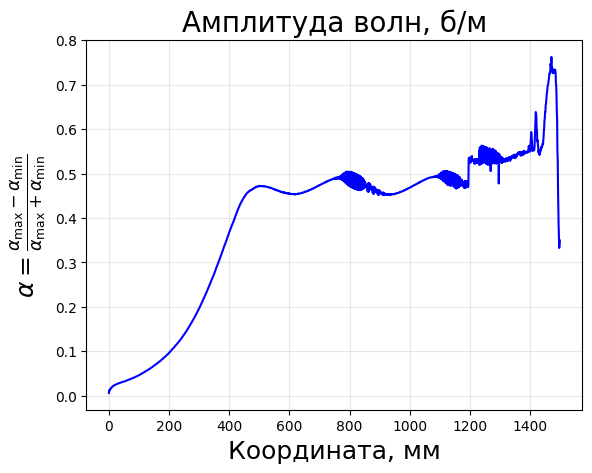

In [11]:
plt.plot(x_coords, ampl_waves, 'b-')
plt.xlabel('Координата, мм', fontsize=18)
plt.ylabel(r'$\alpha = \frac{\alpha_{\max} - \alpha_{\min}}{\alpha_{\max} + \alpha_{\min}}$', fontsize=18)
plt.grid(True, alpha=0.3)
plt.title(f'Амплитуда волн, б/м', fontsize=20)
plt.show()

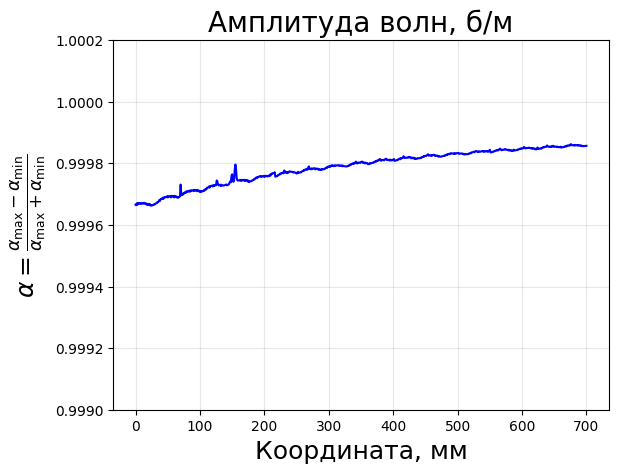

In [12]:
data = np.loadtxt(filename, skiprows=2, delimiter=',')
data_slice = data[index:, :]
max_val = np.max(data_slice, axis=1, keepdims=False)
min_val = np.min(data_slice, axis=1, keepdims=False)
ampl_waves = (max_val-min_val)/(min_val+max_val)
x_coords = np.arange(0, len(ampl_waves), 1)
plt.plot(x_coords, ampl_waves, 'b-')
plt.xlabel('Координата, мм', fontsize=18)
plt.ylabel(r'$\alpha = \frac{\alpha_{\max} - \alpha_{\min}}{\alpha_{\max} + \alpha_{\min}}$', fontsize=18)
plt.grid(True, alpha=0.3)
plt.ylim([0.999,1.0002])
plt.title(f'Амплитуда волн, б/м', fontsize=20)
plt.show()

In [13]:
index = np.argmax(data_time[data_time>0.2])

In [14]:
data_time[data_time>0.2][0]

np.float64(0.20098)

In [15]:
index 

np.int64(978)

In [16]:
data = np.loadtxt(filename, skiprows=2, delimiter=',')

In [17]:
data 

array([[9.6296e-04, 1.9151e-04, 1.9151e-04, ..., 1.9128e-04, 1.9128e-04,
        1.9128e-04],
       [1.9630e-03, 1.9180e-04, 1.9195e-04, ..., 1.9128e-04, 1.9128e-04,
        1.9128e-04],
       [2.9630e-03, 1.9207e-04, 1.9242e-04, ..., 1.9128e-04, 1.9128e-04,
        1.9127e-04],
       ...,
       [1.1770e+00, 1.9031e-04, 1.8901e-04, ..., 1.6949e-04, 1.7316e-04,
        1.8141e-04],
       [1.1780e+00, 1.9045e-04, 1.8922e-04, ..., 1.7647e-04, 1.7954e-04,
        1.9042e-04],
       [1.1790e+00, 1.9064e-04, 1.8949e-04, ..., 1.8086e-04, 1.8253e-04,
        1.9177e-04]], shape=(1179, 1501))

In [18]:
data_slice = np.copy(data[index:, :])

In [19]:
data_slice

array([[9.7898e-01, 1.9114e-04, 1.9146e-04, ..., 2.0734e-04, 2.0728e-04,
        2.1077e-04],
       [9.7998e-01, 1.9090e-04, 1.9109e-04, ..., 2.0351e-04, 2.0344e-04,
        2.0666e-04],
       [9.8098e-01, 1.9067e-04, 1.9071e-04, ..., 1.9951e-04, 1.9964e-04,
        2.0315e-04],
       ...,
       [1.1770e+00, 1.9031e-04, 1.8901e-04, ..., 1.6949e-04, 1.7316e-04,
        1.8141e-04],
       [1.1780e+00, 1.9045e-04, 1.8922e-04, ..., 1.7647e-04, 1.7954e-04,
        1.9042e-04],
       [1.1790e+00, 1.9064e-04, 1.8949e-04, ..., 1.8086e-04, 1.8253e-04,
        1.9177e-04]], shape=(201, 1501))

In [20]:
data = pd.read_csv(filename, sep=',', header=1, low_memory=False)

In [21]:
data 

,Time,N1,N2,N3,N4,N5,N6,N7,N8,N9,...,N1491,N1492,N1493,N1494,N1495,N1496,N1497,N1498,N1499,N1500
0,0.000963,0.000192,0.000192,0.000191,0.000191,0.000191,0.000191,0.000191,0.000191,0.000191,...,0.000191,0.000191,0.000191,0.000191,0.000191,0.000191,0.000191,0.000191,0.000191,0.000191
1,0.001963,0.000192,0.000192,0.000192,0.000192,0.000192,0.000192,0.000192,0.000192,0.000192,...,0.000191,0.000191,0.000191,0.000191,0.000191,0.000191,0.000191,0.000191,0.000191,0.000191
2,0.002963,0.000192,0.000192,0.000192,0.000192,0.000192,0.000192,0.000192,0.000192,0.000192,...,0.000191,0.000191,0.000191,0.000191,0.000191,0.000191,0.000191,0.000191,0.000191,0.000191
3,0.003963,0.000192,0.000193,0.000193,0.000193,0.000193,0.000193,0.000193,0.000193,0.000192,...,0.000191,0.000191,0.000191,0.000191,0.000191,0.000191,0.000191,0.000191,0.000191,0.000191
4,0.005000,0.000192,0.000193,0.000193,0.000193,0.000193,0.000193,0.000193,0.000193,0.000193,...,0.000191,0.000191,0.000191,0.000191,0.000191,0.000191,0.000191,0.000191,0.000191,0.000191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1174,1.175000,0.000190,0.000189,0.000189,0.000189,0.000188,0.000188,0.000188,0.000188,0.000188,...,0.000123,0.000130,0.000137,0.000142,0.000151,0.000156,0.000165,0.000167,0.000178,0.000183
1175,1.176000,0.000190,0.000189,0.000189,0.000189,0.000188,0.000188,0.000188,0.000188,0.000188,...,0.000114,0.000121,0.000131,0.000138,0.000149,0.000154,0.000166,0.000165,0.000174,0.000177
1176,1.177000,0.000190,0.000189,0.000189,0.000189,0.000188,0.000188,0.000188,0.000188,0.000188,...,0.000110,0.000116,0.000122,0.000131,0.000138,0.000147,0.000155,0.000169,0.000173,0.000181
1177,1.178000,0.000190,0.000189,0.000189,0.000189,0.000189,0.000189,0.000188,0.000188,0.000188,...,0.000110,0.000115,0.000124,0.000134,0.000142,0.000153,0.000163,0.000176,0.000180,0.000190


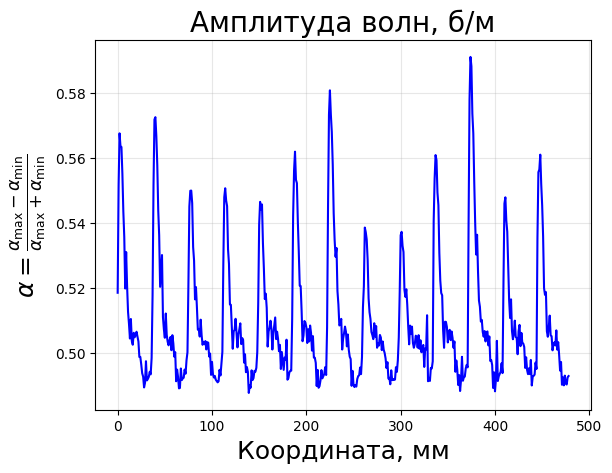

In [37]:
data_slice = np.copy(data[data['Time']>0.7].iloc[:,1:])
max_val = np.max(data_slice, axis=1, keepdims=False)
min_val = np.min(data_slice, axis=1, keepdims=False)
ampl_waves = (max_val-min_val)/(min_val+max_val)
x_coords = np.arange(0, len(ampl_waves), 1)
plt.plot(x_coords, ampl_waves, 'b-')
plt.xlabel('Координата, мм', fontsize=18)
plt.ylabel(r'$\alpha = \frac{\alpha_{\max} - \alpha_{\min}}{\alpha_{\max} + \alpha_{\min}}$', fontsize=18)
plt.grid(True, alpha=0.3)
#plt.ylim(0.4,0.7)
plt.title(f'Амплитуда волн, б/м', fontsize=20)
plt.show()

In [38]:
ampl_waves.shape

(479,)

In [39]:
data_slice.shape

(479, 1500)

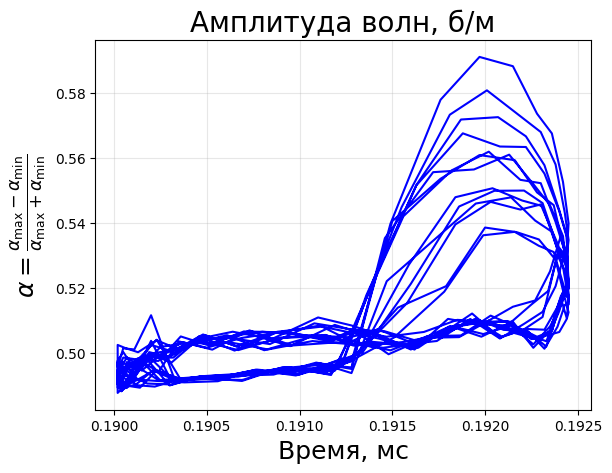

In [47]:
dt_step = 0.001
x_frac_start = 0.3 
x_frac_end = 0.8
t_start = 0.7
tf_ind = int(t_start/dt_step)
data = np.loadtxt(filename, skiprows=2, delimiter=',')
data_time = data[:,1]*1.0e3 
data = data[:, 1:]*1.0e3 
data_amlitude = np.copy(data[tf_ind:, :])
max_val = np.max(data_amlitude, axis=1, keepdims=False)
min_val = np.min(data_amlitude, axis=1, keepdims=False)
amlitude = (max_val - min_val)/(max_val + min_val)
x_coords = data_time[tf_ind:]
plt.plot(x_coords, amlitude, 'b-')
plt.xlabel('Время, мс', fontsize=18)
plt.ylabel(r'$\alpha = \frac{\alpha_{\max} - \alpha_{\min}}{\alpha_{\max} + \alpha_{\min}}$', fontsize=18)
plt.grid(True, alpha=0.3)
plt.title(f'Амплитуда волн, б/м', fontsize=20)
plt.show()